In [1]:
import requests
import json
import pandas as pd
import re
import time
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import nltk
from nltk.tokenize import word_tokenize
import csv
import spacy
from collections import Counter
from textblob import TextBlob
from nltk.corpus import stopwords
from scipy.stats import pearsonr

In [ ]:
# ---- INITIAL SETUP FOR LIBRARIES AND CONFIGURATIONS ----
# Set up necessary directories and configurations:
os.makedirs('data', exist_ok=True)

# Create a session to handle requests with retries
session = requests.Session()
retries = Retry(total=3, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))

# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')

# ---- SCRAPING LOVECRAFT CONTENT ----
def clean_title(title):
    """
    Clean the title by removing author names (like 'by H. P. Lovecraft' or 'by C. M. Eddy, Jr.')
    """
    # Remove any mention of "by" or "with" along with author names
    title = re.sub(r'(by\s*H\.?\s*P\.?\s*Lovecraft|with\s*H\.?\s*P\.?\s*Lovecraft)', '', title, flags=re.IGNORECASE).strip()
    title = re.sub(r'(by\s+[a-zA-Z\.\,]+)', '', title, flags=re.IGNORECASE).strip()

    # Remove extra spaces or redundant punctuation
    title = ' '.join(title.split())
    
    return title

def scrape_lovecraft_content():
    """
    Scrape Lovecraft's fiction from the website and save it to a CSV file.
    """
    base_url = "https://www.hplovecraft.com/writings/texts/"
    response = session.get(base_url)
    
    if response.status_code != 200:
        print(f"Failed to access the base URL: {response.status_code}")
        return
    
    soup = BeautifulSoup(response.content, 'html.parser')
    content_links = [
        f"{base_url}{link['href']}"
        for link in soup.find_all('a', href=True)
        if link['href'].startswith('fiction/') and not link['href'].startswith('#')
    ]

    csv_filename = 'data/lovecraft_fiction.csv'
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Content Type', 'Title', 'Text'])

        for content_url in content_links:
            time.sleep(random.uniform(1, 3))  # Avoid being flagged by too many requests
            try:
                content_response = session.get(content_url, headers={'User-Agent': 'Mozilla/5.0'})
                if content_response.status_code == 200:
                    content_soup = BeautifulSoup(content_response.content, 'html.parser')
                    title_tag = content_soup.find('font', size="+2")
                    text_div = content_soup.find('div', align='justify')

                    if title_tag and text_div:
                        title = title_tag.get_text(strip=True)
                        title = clean_title(title)  # Clean the title to remove authors
                        csvwriter.writerow(["fiction", title, text_div.get_text(strip=True)])
                        print(f'Scraped: {title}')
                    else:
                        print(f'Title or text not found for {content_url}')
                else:
                    print(f'Failed to scrape {content_url}: {content_response.status_code}')
            except Exception as e:
                print(f'Error scraping {content_url}: {e}')

# Run the scraping function
scrape_lovecraft_content()

  Content Type                                              Title  \
0      fiction                                      The Alchemist   
1      fiction                                 Ashes M. Eddy, Jr.   
2      fiction                        At the Mountains of Madness   
3      fiction                                           Azathoth   
4      fiction  The Battle that Ended the Century(MS. Found in...   

                                                Text  
0  High up, crowning the grassy summit of a swell...  
1  “Hello, Bruce. Haven’t seen you in a dog’s age...  
2  I.I am forced into speech because men of scien...  
3  When age fell upon the world, and wonder went ...  
4  [Note: Barlow’s contributions are in brackets....  
                                               Title  Word Count
0                                      The Alchemist        3252
1                                 Ashes M. Eddy, Jr.        2557
2                        At the Mountains of Madness       3

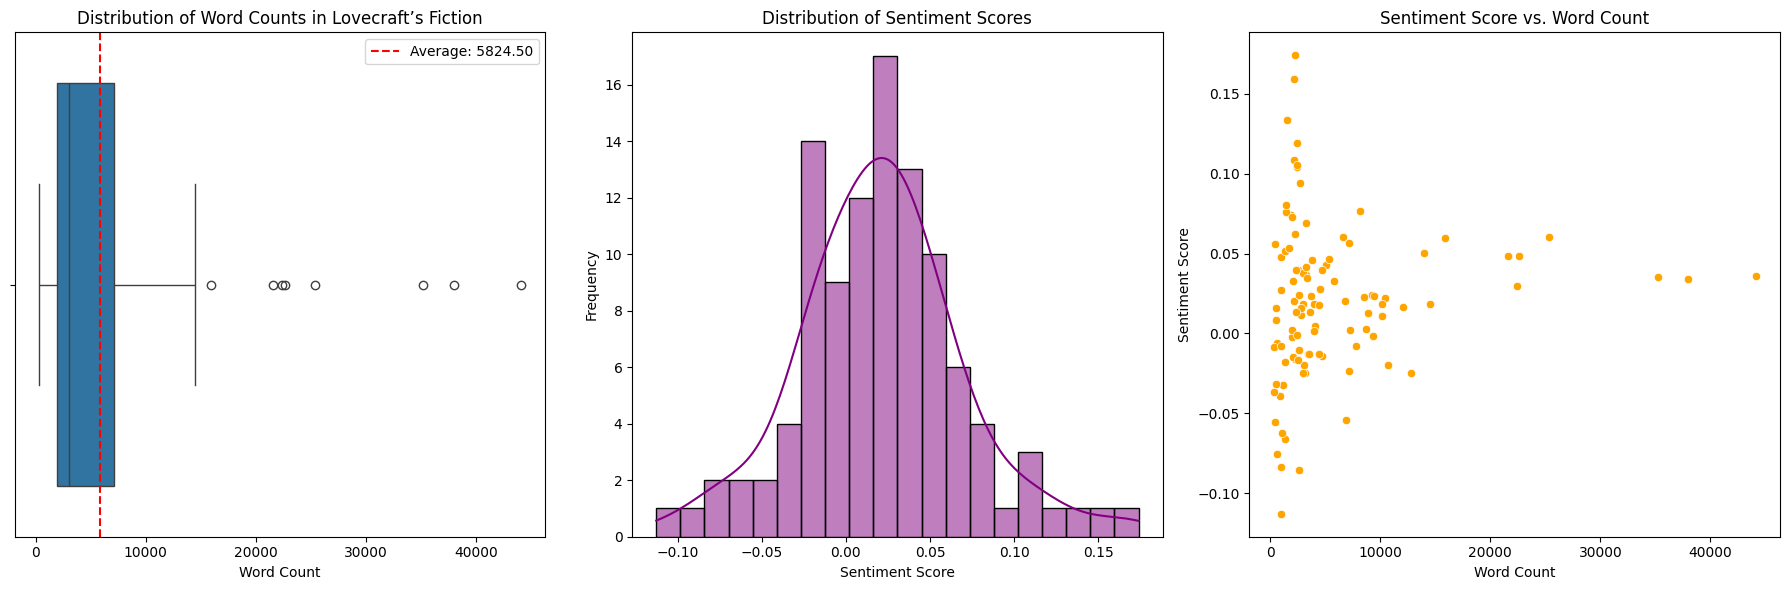

Pearson's correlation coefficient: 0.11
P-value: 0.2508
The correlation is not statistically significant.
[('could', 2308), ('one', 2066), ('would', 1816), ('old', 1367), ('seemed', 1165), ('time', 1126), ('great', 1041), ('even', 1034), ('must', 1004), ('man', 992), ('saw', 971), ('though', 968), ('like', 955), ('things', 921), ('found', 872), ('came', 861), ('might', 790), ('upon', 789), ('thing', 754), ('made', 753), ('long', 733), ('whose', 722), ('never', 721), ('still', 716), ('strange', 712), ('night', 694), ('much', 684), ('place', 670), ('first', 665), ('knew', 653), ('see', 650), ('come', 645), ('back', 644), ('last', 640), ('men', 638), ('certain', 622), ('many', 622), ('thought', 622), ('know', 615), ('yet', 593), ('something', 592), ('beyond', 573), ('two', 573), ('heard', 571), ('house', 567), ('black', 558), ('told', 548), ('way', 547), ('world', 543), ('almost', 543), ('seen', 543), ('little', 539), ('said', 539), ('ever', 525), ('since', 518), ('new', 518), ('felt', 51

In [2]:
# ---- LOAD SCRAPED DATA INTO DATAFRAME ----
df = pd.read_csv('data/lovecraft_fiction.csv')

# View first few rows
print(df.head())

# ---- TEXT ANALYSIS ----
# Count the number of words per story (excluding commas and other punctuation)
df['Word Count'] = df['Text'].apply(lambda text: len([word for word in text.split() if word.isalpha()]))

# View the updated dataframe with word counts
print(df[['Title', 'Word Count']].head())

# ---- PERFORM SENTIMENT ANALYSIS ----
# 1. Calculate Text Length (Character Counts)
df['Text Length'] = df['Text'].apply(len)

# 2. Perform Sentiment Analysis (polarity)
def get_sentiment(text):
    """
    Perform sentiment analysis using TextBlob to return sentiment polarity (-1 to 1)
    """
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to each story
df['Sentiment'] = df['Text'].apply(get_sentiment)

# View the dataframe with Text Length and Sentiment columns
print(df[['Title', 'Text Length', 'Sentiment']].head())

# ---- GROUP AND ANALYZE DATA ----
# Group by Word Count, Text Length (Character Count), and Sentiment, then get the frequency of each combination
grouped_df = df.groupby(['Word Count', 'Text Length', 'Sentiment']).size().reset_index(name='Frequency')

# View the head and tail of the grouped dataframe
print("Head of the grouped dataframe:")
print(grouped_df.head())
print("\nTail of the grouped dataframe:")
print(grouped_df.tail())

# ---- DATA VISUALIZATION ----
# Set up the figure for all plots to be displayed in one cell
plt.figure(figsize=(18, 6))

# Plot 1: Average Word Count Distribution
plt.subplot(1, 3, 1)
sns.boxplot(x=df['Word Count'])
plt.axvline(df['Word Count'].mean(), color='red', linestyle='--', label=f'Average: {df["Word Count"].mean():.2f}')
plt.title('Distribution of Word Counts in Lovecraft’s Fiction')
plt.xlabel('Word Count')
plt.legend()

# Plot 2: Sentiment Score Distribution
plt.subplot(1, 3, 2)
sns.histplot(df['Sentiment'], kde=True, color='purple', bins=20)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Plot 3: Sentiment vs. Word Count (Bivariate plot)
plt.subplot(1, 3, 3)
sns.scatterplot(x='Word Count', y='Sentiment', data=df, color='orange')
plt.title('Sentiment Score vs. Word Count')
plt.xlabel('Word Count')
plt.ylabel('Sentiment Score')

# Show all plots together
plt.tight_layout()
plt.show()

# ---- PEARSON CORRELATION ----
# Compute Pearson correlation between Word Count and Sentiment Score
correlation, p_value = pearsonr(df['Word Count'], df['Sentiment'])
print(f"Pearson's correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpret the p-value
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

# ---- TEXT CLEANING AND FREQUENCY ANALYSIS ----
def clean_text(text):
    """
    Tokenize and remove stopwords from the text.
    """
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return " ".join(cleaned_tokens)

# Apply to text column in DF
df['Cleaned_Text'] = df['Text'].apply(clean_text)

# Create frequency distribution for words
all_words = " ".join(df['Cleaned_Text']).split()
word_freq = Counter(all_words)

# Display most common words
print(word_freq.most_common(100))

# ---- ENTITY RECOGNITION USING SPAcy ----
nlp = spacy.load("en_core_web_sm")

# List of Lovecraftian entities
lovecraftian_entities = [
    "cthulhu", "yog-sothoth", "nyarlathotep", "azathoth", "hastur", "r'lyeh", "dagon", 
    "shub-niggurath", "the great old ones", "elder gods", "the old ones", "the deep ones", "night gaunts", 
    "cthulhu cult", "the nameless city", "the black stone", "the dreamlands", "fenric", "hecuba", 
    "animus", "tor-gasukk", "moloch", "kai'lizakia", "lloigor", "eidolon", "derleth", "gog", "magog", "to'koth", 
    "karnas'koi", "traguam", "archon", "mi'en kalarash", "kwundaar", "volund", "k'thun", "noth-yidik", "tru'nembra", 
    "tulzscha", "cxaxukluth", "d'endrrah", "ubbo-sathla", "xexanoth", "ycnàgnnisssz", "yhoundeh", "aiueb gnshal", 
    "aletheia", "azhorra-tha", "c'thalpa", "daoloth", "ghroth", "glaaki"
]

# Function to identify these entities in a text
def find_lovecraftian_entities(text):
    """
    Identify Lovecraftian entities in the text using spaCy.
    """
    doc = nlp(text.lower())  # Convert to lowercase to improve matching
    found_entities = [ent.text for ent in doc.ents if any(entity in ent.text for entity in lovecraftian_entities)]
    return found_entities

# Apply to the cleaned text
df['Lovecraftian Entities'] = df['Cleaned_Text'].apply(find_lovecraftian_entities)

# Display most common entities
entity_freq = Counter([entity for sublist in df['Lovecraftian Entities'] for entity in sublist])
print(entity_freq.most_common(100))
